## 模型選擇
問題：
- 不論是傳統機器學習還是深度學習都有許多的模型可以選擇，針對一個專案要進行時，開始建立模型除了已對產業知識相當了解，知道有哪一些模型會表現得好之外，我們還可能過什麼方式去選擇模型?
- 將可能的選擇(當然要在成本、預算考量下)，全部跑過一次，直接比較表現嗎? 這可能會發生 **剛好** 模型表現不錯，在統計學，你可以說選到偏頗的樣本，錯誤的將其看成該模型的總體表現，這就可能會產生最開始就選擇一個表現不會太好的模型，從而導致專案效果不如預期。

解決方法:
- 融入統計學觀念、視覺化方法，將模型表現經過k-fold，產出多次表現，進而使用統計檢定/視覺化方法幫助觀察哪一個適合當作模型的baseline 選擇。
    - note: 要注意的是，這樣拆解產出的效果，是沒有符合部分檢定的假設，但還是可以當做初步的參考! 這部分詳細討論可以參考 [medium](https://towardsdatascience.com/statistical-tests-for-comparing-classification-algorithms-ac1804e79bb7) 
     
     

In [1]:
# model

from sklearn import linear_model
from sklearn import ensemble
from sklearn import tree
from sklearn import svm
from sklearn import neighbors
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# split data
from sklearn import model_selection

# data transform
from sklearn import preprocessing

# metrics
from sklearn.metrics import mean_absolute_error, median_absolute_error

# vis
import matplotlib.pyplot as plt

# time
import time

## 步驟
1. 建立想測試模型的list
2. [K-fold 或者其他切分方式](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)
3. 訓練測試模型並預測結果
    - [scoring 參考](https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules)
4. 統計檢定 / 視覺化 選擇出baseline模型

In [2]:
def create_model_list():
    models = []
    models.append(('Lasso', linear_model.Lasso()))
    models.append(('Ridge', linear_model.Ridge()))
    models.append(('EN', linear_model.ElasticNet()))
    models.append(('RandomForest', ensemble.RandomForestRegressor()))
    models.append(('KNR', neighbors.KNeighborsRegressor()))
    models.append(('DT', tree.DecisionTreeRegressor()))
    models.append(('ET', tree.ExtraTreeRegressor()))
    models.append(('LGBM', LGBMRegressor()))
    models.append(('XGB', XGBRegressor()))
    models.append(('GBM', ensemble.GradientBoostingRegressor()))
    models.append(("SVR", svm.LinearSVR()))
    return models


def train_models(X, y, models: list, n_splits: int, shuffle: bool, metric: str) -> dict:
    results = []
    
    for m_name, model in models:
        print(f'模型: {m_name}: 訓練中...')
        t = time.time()
        
        cv = model_selection.KFold(n_splits=n_splits, shuffle=shuffle)
        cv_results = model_selection.cross_val_score(estimator=model, X=X, y=y, scoring=metric, cv=cv, n_jobs=-1)
        
        time_cost = time.time()-t
        results.append((m_name, cv_results, time_cost))
        print(f"模型表現 {metric}: \n 平均: {cv_results.mean()}\n 標準差: {cv_results.std()} \n 花費時間: {time_cost}")
        print('-'*30)
    return results


def visualize_model_performance(results: list):
    # Compare our models in a box plot
    
    fig = plt.figure(figsize=(12,7))
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot([e[1] for e in results])
    ax.set_xticklabels([e[0] for e in results])
    plt.show()

(506, 13) (506,)
模型: Lasso: 訓練中...
模型表現 neg_mean_squared_error: 
 平均: -40.605845627892634
 標準差: 22.67078563363359 
 花費時間: 7.342048406600952
------------------------------
模型: Ridge: 訓練中...
模型表現 neg_mean_squared_error: 
 平均: -36.84237612073211
 標準差: 23.078769874783887 
 花費時間: 0.031999826431274414
------------------------------
模型: EN: 訓練中...
模型表現 neg_mean_squared_error: 
 平均: -39.47156340421474
 標準差: 19.841834571849947 
 花費時間: 0.03100275993347168
------------------------------
模型: RandomForest: 訓練中...
模型表現 neg_mean_squared_error: 
 平均: -21.87664058870121
 標準差: 13.31760608811424 
 花費時間: 1.3619987964630127
------------------------------
模型: KNR: 訓練中...
模型表現 neg_mean_squared_error: 
 平均: -29.55021237041351
 標準差: 10.895678740023865 
 花費時間: 0.02404475212097168
------------------------------
模型: DT: 訓練中...
模型表現 neg_mean_squared_error: 
 平均: -43.01542418947777
 標準差: 18.874150941568306 
 花費時間: 0.02599787712097168
------------------------------
模型: ET: 訓練中...
模型表現 neg_mean_squared_error: 
 平均: -

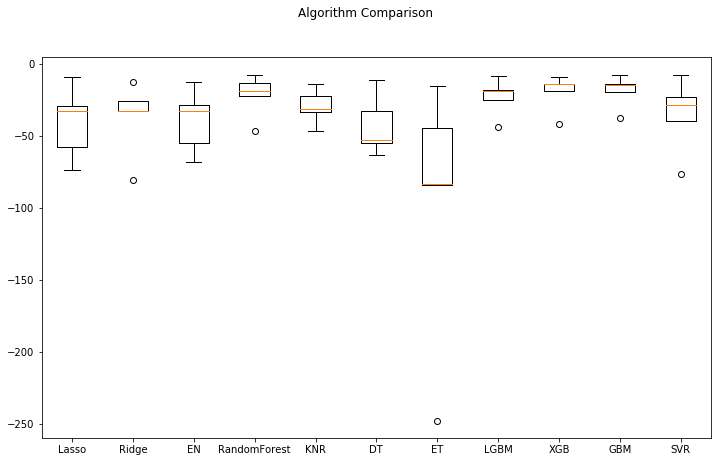

In [3]:
# 簡單使用內建資料集
from sklearn.datasets import load_boston
X, y = load_boston(return_X_y=True)
print(X.shape, y.shape)

# 標準化
X = preprocessing.StandardScaler().fit_transform(X)

# 步驟
models = create_model_list()
results = train_models(X, y, models, 5, False, 'neg_mean_squared_error')
visualize_model_performance(results)

## 結論
- 根據視覺化結果tree-based模型表現得比較穩定，可以當作基礎模型去使用。
- 若不考慮模型速度，也可以使用emsemble方法挑多個baseline去進一步增進最後的效果。